Use this notebook to run 1 denoiser step and get updated intermediate steps

In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200, precision=3)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers.umer_debug_logger import udl

In [4]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [5]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

In [6]:
assert cnxs.config.control_attention_head_dim==64
assert cnxs.control_model.down_blocks[1].attentions[0].transformer_blocks[0].attn1.heads==1

In [7]:
cnxs.base_model = sdxl_pipe.unet

The example script of Heidelberg manually sets scale_list to 0.95

In [8]:
cnxs.scale_list = cnxs.scale_list * 0. + 0.95
assert cnxs.scale_list[0] == .95

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [9]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

In [10]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

___

## Run

In [11]:
import torch
import random
import numpy as np
import cv2
from diffusers.utils import load_image
import matplotlib.pyplot as plt

class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

def get_canny_edges(image, threshold=(100, 250)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    edges = edges / 255.
    return edges

def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    
seed_everything(123456)

In [12]:
prompt = 'aerial view, a futuristic research complex in a bright foggy jungle, hard lighting'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

guiding_image = load_image(
    "https://hf.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png"
)

edges_tensor = torch.tensor(get_canny_edges(guiding_image))
three_edges = torch.stack((edges_tensor,edges_tensor,edges_tensor))

In [13]:
def get_cnxs_image(ctrl_scale):
    seed_everything(123456)
    return cnxs_pipe(prompt, negative_prompt=neg_prompt,image=three_edges, control_scale=ctrl_scale).images[0]

In [14]:
ims = []
for cs in torch.arange(0,1.01,0.2):
    im = get_cnxs_image(ctrl_scale=cs)
    ims.append((cs,im))

/Users/umer/Documents/GitHub/diffusers/diffusers/src/diffusers/models/controlnetxs.py:434: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.scale_list = torch.tensor(scale_list)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
plt.show(ims[0][1])

In [16]:
from util_plot import make_channel_last

def shape(o): return o.shape if hasattr(o,'shape') else o.size

def make_channel_last(im): return einops.rearrange(im, 'c w h-> w h c') if shape(im)[0] in (1,3) else im

def compare_images(images, titles=None, figsize=(2, 2)):
    n = len(images)
    if titles is None: titles = [None] * n
    elif len(titles) != n: raise ValueError("Number of titles must match number of images")

    plt.figure(figsize=(figsize[0] * n, figsize[1]))

    for i, image in enumerate(images):
        plt.subplot(1, n, i + 1)
        plt.imshow(make_channel_last(image))
        if titles[i] is not None: plt.title(titles[i])

        plt.xticks([])
        plt.yticks([])
    
    plt.show()
    

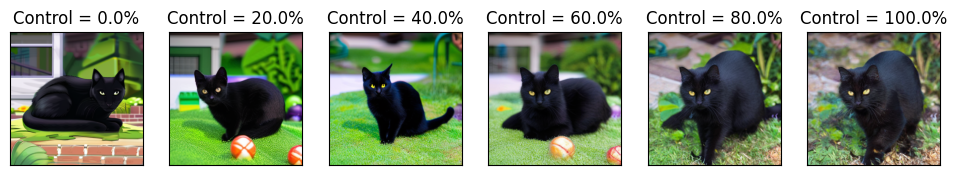

In [17]:
compare_images(
    [im for cs,im in ims],
    [str(f'Control = {cs*100:.1f}%') for cs,im in ims],
)